In [49]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [50]:
import sklearn
from sklearn.datasets import make_circles

### Data


In [51]:
# make a thousand samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [52]:
len(X), len(y)

(1000, 1000)

In [53]:
print(f"First five samples of X: {X[:5]}")
print(f"First five samples of Y: {y[:5]}")

First five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First five samples of Y: [1 1 1 1 0]


In [54]:
# Make dataframe of the corcle data
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label" : y[:]})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


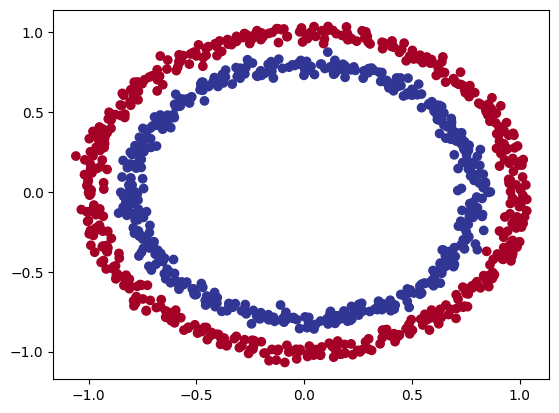

In [55]:
# visualize visualiize visualize
plt.scatter(circles["X1"], circles["X2"],
            c = circles['label'],
            cmap = plt.cm.RdYlBu)

In [56]:
# check input and output shape
X.shape, y.shape, type(X)

((1000, 2), (1000,), numpy.ndarray)

In [57]:
X_sample = X[0]
y_sample = y[0]

print(f"valye of one sample of X: {X_sample} and the sampe for y : {y_sample}")
print(f"shape of one sample of X: {X_sample.shape} and the sampe for y : {y_sample.shape}")

valye of one sample of X: [0.75424625 0.23148074] and the sampe for y : 1
shape of one sample of X: (2,) and the sampe for y : ()


In [58]:
# convert the data to tensors

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [59]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size  = 0.2,
                                                    random_state=42)

In [61]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Building a model

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
class CircleModelV0( nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)


  def forward(self, X: torch.tensor) -> torch.tensor:
    return self.layer2(self.layer1(X))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [64]:
next(model_0.parameters()).device

device(type='cpu')

In [65]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer2.bias', tensor([-0.2060]))])

In [66]:
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))
  print(f"predictions samples : {y_logits[:5]}")
  print(f"actual labels : {y_test[:5]}")

predictions samples : tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]])
actual labels : tensor([1., 0., 1., 0., 1.])


## loss fun and optimizer

In [67]:
loss_fn = torch.nn.BCEWithLogitsLoss() # sigmpid activation built in
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1, momentum = 0.9)


In [68]:
#Accuracy metrix = true+ve / total

def accuracy_fn (y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct/len(y_pred))*100

## Train the model

In [69]:
y_preds = torch.sigmoid(y_logits).round().squeeze()
y_preds[:5]

tensor([0., 0., 0., 0., 0.])

In [70]:
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device),  y_train.to(device), y_test.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch = 100

for epoch in range(epoch):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_preds = torch.sigmoid(y_logits).round()

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate test loss and accuracy

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                    y_pred = test_pred)

    # Print out what is happeneing
    if epoch %10 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69334, Accuracy: 52.50% | Test loss: 0.69681, Test acc: 48.00%
Epoch: 20 | Loss: 0.69302, Accuracy: 52.25% | Test loss: 0.69512, Test acc: 46.50%
Epoch: 30 | Loss: 0.69307, Accuracy: 47.75% | Test loss: 0.69453, Test acc: 46.50%
Epoch: 40 | Loss: 0.69301, Accuracy: 52.00% | Test loss: 0.69474, Test acc: 47.00%
Epoch: 50 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69452, Test acc: 46.00%
Epoch: 60 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69459, Test acc: 46.00%
Epoch: 70 | Loss: 0.69298, Accuracy: 51.38% | Test loss: 0.69470, Test acc: 46.00%
Epoch: 80 | Loss: 0.69298, Accuracy: 51.25% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 90 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69469, Test acc: 46.00%


### Make preds with out model

In [71]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})



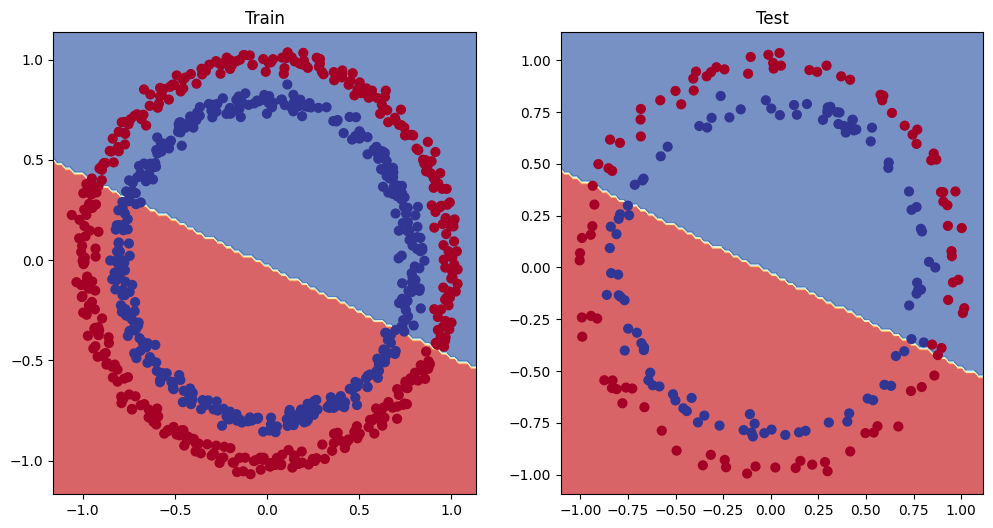

In [72]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X = X_train, y = y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X = X_test, y = y_test)


In [89]:
class CircleModelV1( nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=64)
    self.layer_2 = nn.Linear(in_features=64, out_features=256)
    self.layer_3 = nn.Linear(in_features=256, out_features=16)
    self.layer_4 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()
  def forward(self, X: torch.tensor) -> torch.tensor:
    return self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=16, bias=True)
  (layer_4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [90]:
loss_fn = torch.nn.BCEWithLogitsLoss() # sigmpid activation built in
optimizer = torch.optim.SGD(params = model_1.parameters(), lr = 0.1, momentum=0.9)

In [91]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch = 1000

for epoch in range(epoch):

  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_preds = torch.sigmoid(y_logits).round()

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    #forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate test loss and accuracy

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                    y_pred = test_pred)

    # Print out what is happeneing
    if epoch %100 ==0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69343, Accuracy: 50.00% | Test loss: 0.69369, Test acc: 50.00%
Epoch: 100 | Loss: 0.08003, Accuracy: 99.50% | Test loss: 0.09415, Test acc: 99.00%
Epoch: 200 | Loss: 0.00141, Accuracy: 100.00% | Test loss: 0.00576, Test acc: 100.00%
Epoch: 300 | Loss: 0.00084, Accuracy: 100.00% | Test loss: 0.00454, Test acc: 100.00%
Epoch: 400 | Loss: 0.00060, Accuracy: 100.00% | Test loss: 0.00386, Test acc: 100.00%
Epoch: 500 | Loss: 0.00047, Accuracy: 100.00% | Test loss: 0.00341, Test acc: 100.00%
Epoch: 600 | Loss: 0.00038, Accuracy: 100.00% | Test loss: 0.00307, Test acc: 100.00%
Epoch: 700 | Loss: 0.00032, Accuracy: 100.00% | Test loss: 0.00280, Test acc: 100.00%
Epoch: 800 | Loss: 0.00028, Accuracy: 100.00% | Test loss: 0.00258, Test acc: 100.00%
Epoch: 900 | Loss: 0.00025, Accuracy: 100.00% | Test loss: 0.00241, Test acc: 100.00%


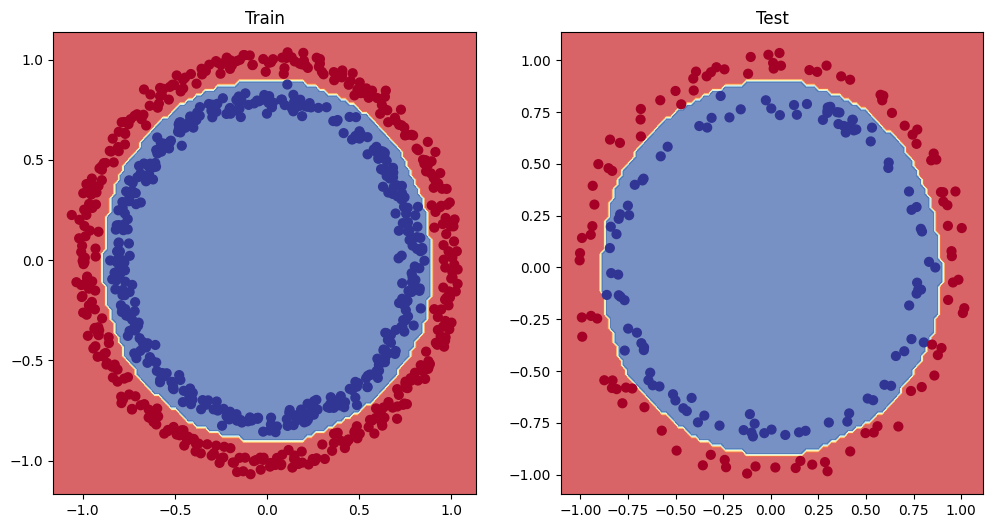

In [92]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X = X_train, y = y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X = X_test, y = y_test)